In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx
import pystan_utils

plt.style.use('ggplot')
%matplotlib inline

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


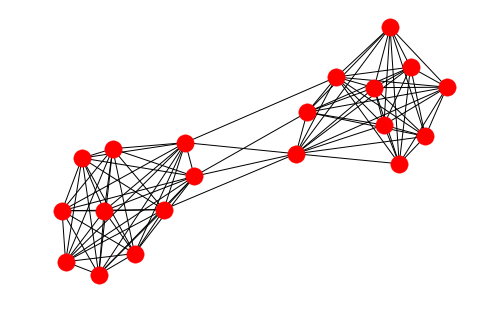

In [2]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [3]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [4]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3be6d669e276c97fe04930ee9ae1728c NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpzs_372ul/stanfit4anon_model_3be6d669e276c97fe04930ee9ae1728c_7737573976150175024.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.vb(data=data, iter=10000)

/home/david/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [6]:
pies = pystan_utils.vb_extract_variable(fit, "pi", var_type="matrix", dims=[k,n])

In [7]:
extract = pystan_utils.vb_extract(fit)

In [8]:
groups = np.argmax(pies,axis=0)

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


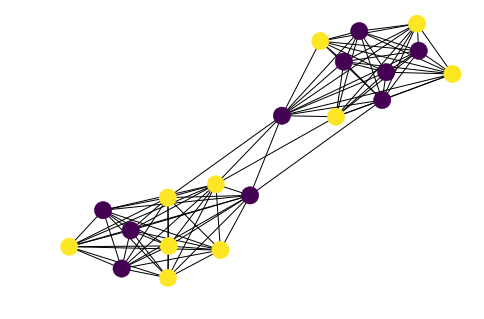

In [9]:
#pi = pies
#groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

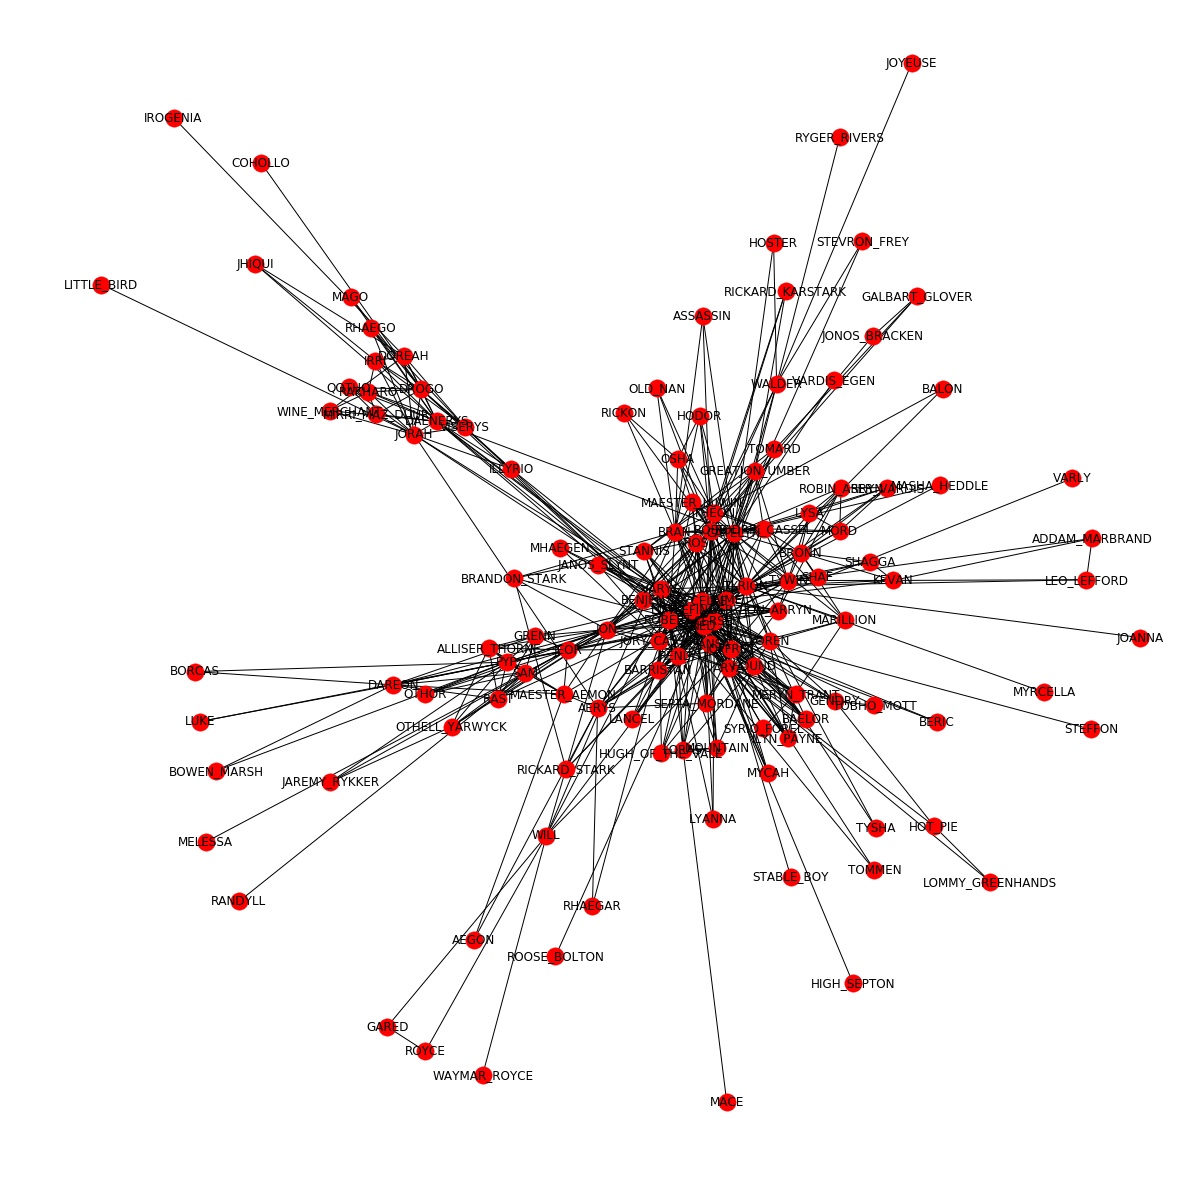

In [10]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s1-nodes.csv')
edges = pd.read_csv('../data/got-s1-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,16))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [11]:
n = graph.shape[0]
k = 5
iterations = 10000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5}

In [12]:
fit = sm.vb(data = data, iter = iterations, output_samples = iterations)

In [16]:
fitvar = pystan_utils.vb_extract(fit)
fitvar[0]

{'pi.1.1': array([0.0052807 , 0.00468327, 0.02046208, ..., 0.00500105, 0.00062992,
        0.00124291]),
 'pi.2.1': array([0.00293898, 0.00171661, 0.00151083, ..., 0.00315912, 0.00389312,
        0.00064603]),
 'pi.3.1': array([0.03747623, 0.04416424, 0.0269446 , ..., 0.0271468 , 0.03663399,
        0.04546371]),
 'pi.4.1': array([0.08830994, 0.06801878, 0.07825239, ..., 0.08804616, 0.09056531,
        0.08104458]),
 'pi.5.1': array([0.40548497, 0.32983762, 0.43650001, ..., 0.38257009, 0.38417815,
        0.36081384]),
 'pi.6.1': array([0.00750978, 0.00373496, 0.00967405, ..., 0.01735806, 0.00597559,
        0.00542531]),
 'pi.7.1': array([0.03239953, 0.0437791 , 0.02459219, ..., 0.04725841, 0.0301387 ,
        0.03030738]),
 'pi.8.1': array([0.00661274, 0.00676462, 0.01043363, ..., 0.00619301, 0.00330061,
        0.00626659]),
 'pi.9.1': array([0.08819213, 0.10079438, 0.09500761, ..., 0.08876078, 0.07903988,
        0.09297143]),
 'pi.10.1': array([0.06602717, 0.062922  , 0.06635517, 

In [14]:
var_names = fit["sampler_param_names"]
samples = np.array([x for x in fit["sampler_params"]])

In [15]:
# Ned stark
plt.hist(fitvar[0]['pi[76,1]'])
plt.hist(fitvar[0]['pi[76,2]'])
plt.hist(fitvar[0]['pi[76,3]'])
plt.hist(fitvar[0]['pi[76,4]'])
plt.hist(fitvar[0]['pi[76,5]'])


KeyError: 'pi[76,1]'

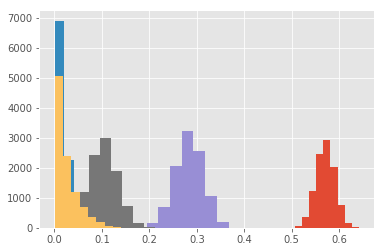

In [321]:
# Robert
plt.hist(fitvar[0]['pi[94,1]'])
plt.hist(fitvar[0]['pi[94,2]'])
plt.hist(fitvar[0]['pi[94,3]'])
plt.hist(fitvar[0]['pi[94,4]'])
plt.hist(fitvar[0]['pi[94,5]'])
plt.show()

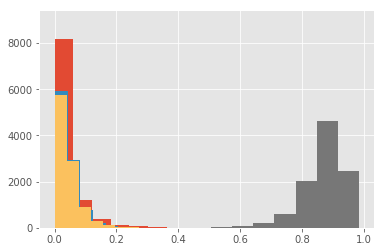

In [322]:
# Cersei
plt.hist(fitvar[0]['pi[18,1]'])
plt.hist(fitvar[0]['pi[18,2]'])
plt.hist(fitvar[0]['pi[18,3]'])
plt.hist(fitvar[0]['pi[18,4]'])
plt.hist(fitvar[0]['pi[18,5]'])
plt.show()

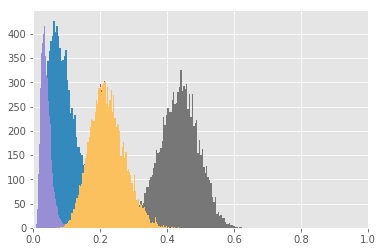

In [351]:
## Varys
plt.hist(fitvar[0]['pi[121,1]'], bins = 100)
plt.hist(fitvar[0]['pi[121,2]'], bins = 100)
plt.hist(fitvar[0]['pi[121,3]'], bins = 100)
plt.hist(fitvar[0]['pi[121,4]'], bins = 100)
plt.hist(fitvar[0]['pi[121,5]'], bins = 100)
plt.xlim(0,1)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

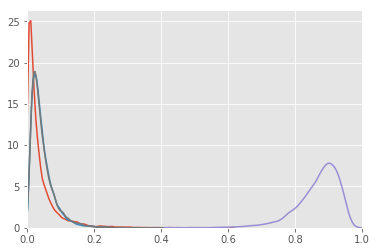

In [345]:
import seaborn as sns
sns.distplot(fitvar[0]['pi[18,1]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,2]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,3]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,4]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,5]'], kde=True, hist=False)
plt.xlim(0, 1)

In [27]:
for key in fitvar[0]:
    if "pi" in key:
        temp.append(fitvar[0][key])
        

In [233]:
test = temp[0]

In [235]:
test.reshape(10000)

array([0.49570249, 0.00500415, 0.25879176, ..., 0.0560985 , 0.16149272,
       0.13844998])

In [38]:
lol =(np.array(temp))

In [248]:
temp[0][0]

0.49570248536308725

In [249]:
temp[0]

array([0.49570249, 0.00500415, 0.25879176, ..., 0.0560985 , 0.16149272,
       0.13844998])

In [242]:
final = np.reshape(lol, (iterations, n, 6))

In [244]:
fix = np.zeros([iterations,n,6])

In [253]:

for i in range(0, iterations):
    for j in range(0,n):
        for z in range(0,6):
            fix[i,j,z] = temp[]

SyntaxError: invalid syntax (<ipython-input-253-f235d5c7057e>, line 1)

In [254]:
k = 6

In [256]:
extract = pystan_utils.vb_extract(fit)
pitest = np.zeros((k,n,iterations))
for ki in range(1,k+1):
    for ni in range(n):
        for it in range(1001):
            pitest[ki-1,ni,it] = extract[0][extract[2][(ki-1)*n + ni]][it]

In [258]:
np.shape(pitest)

(6, 143, 10000)

In [ ]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi,axis = 1)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [296]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha


In [ ]:
groups = fit.extract()["pi"]

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [ ]:
scores = []
for i in range(1, iterations//2):
    cluster1 = np.argmax(groups[i-4], axis = 1)
    cluster2 = np.argmax(groups[i-3], axis = 1)
    scores.append(adjusted_mutual_info_score(cluster1, cluster2))

In [ ]:
plt.plot(scores)

In [14]:
groups = np.argmax(pi_hat,axis = 0)

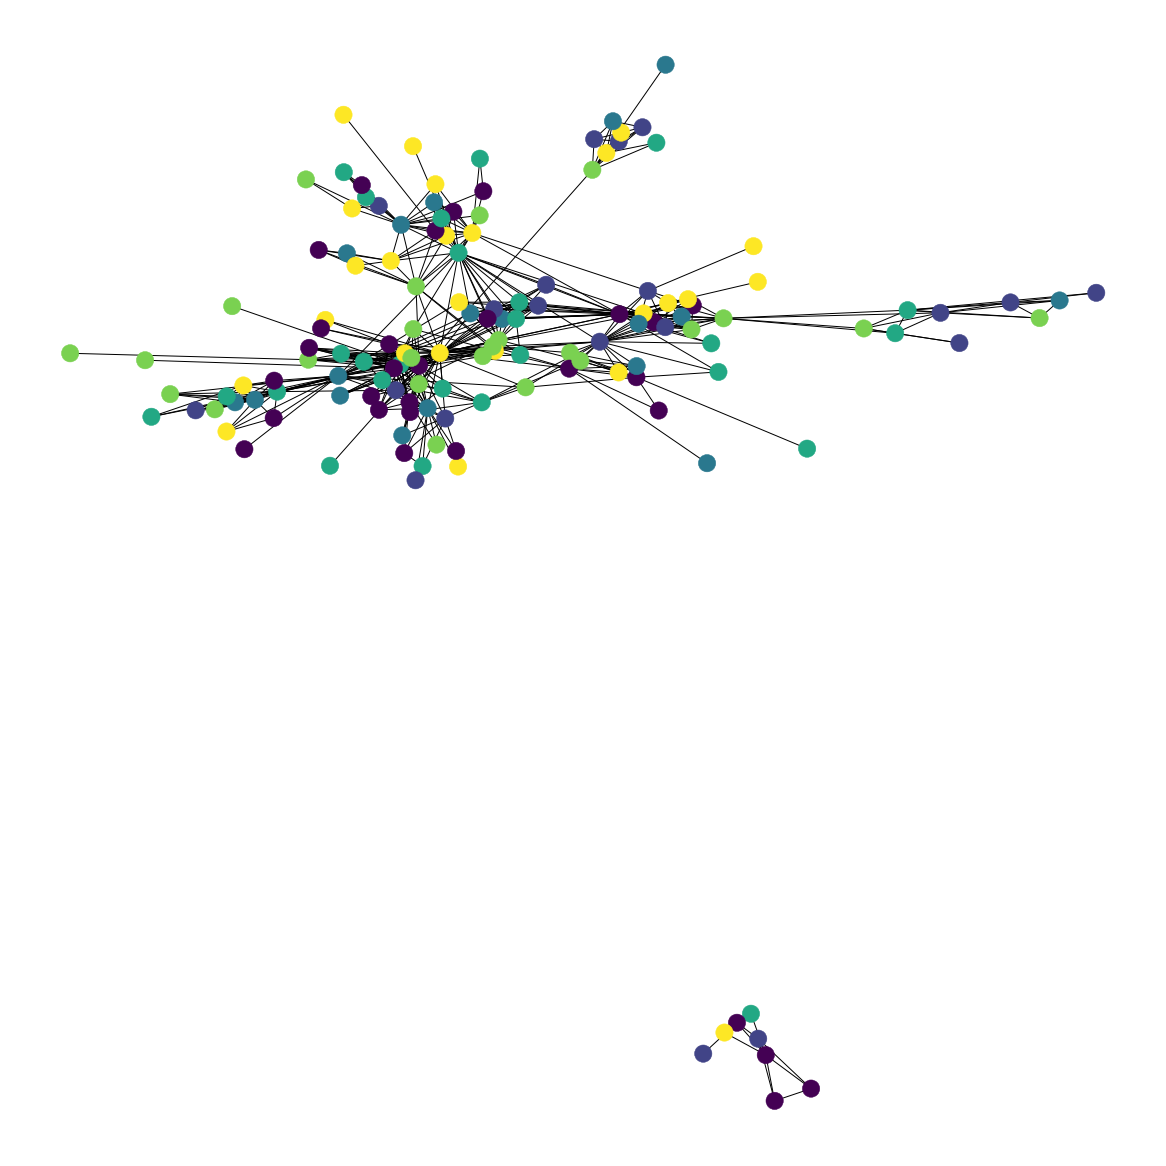

In [15]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

TypeError: data type not understood